In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-61w3qq3n
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-61w3qq3n
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=a313ea4af4df0230681ec1d4054397cdf51e5e3db37a4a8cbbd4306298301ef6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3b8tfjt/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
!pip install keras_applications


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# imports for face verification with the VGGFace2 model->
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
#from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

#imports for our Siamese NN model
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from scipy.spatial.distance import cosine
import os
import glob

In [ ]:
#Helper function to show plot
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
#Helper function to draw image
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
#VGG model loading
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
#Helper function unzipping one zip file -- execution not reqd if data uploaded manually
!unzip  './drive/MyDrive/Celebrity Dataset/part2.zip' -d './data'

In [ ]:
#unmounting drive
! sudo umount -l /content/drive/

umount: /content/drive/: no mount point specified.


In [ ]:
# extract the face from an image not reqd if extracted face BB data uploaded manually
def extract_face(filename, required_size=(100, 100)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if(len(results) > 1):
        raise ValueError('A very specific bad thing happened.');# extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    #cutting the bottom half of the image
    x2, y2 = x1 + width, int(y1 + height/1.7)
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [ ]:


# function not reqd if data uploaded manually

#getting all the list of celebs from the directory (raw image)
entry =  os.listdir('./data/dir_002/')

#creating a path to keep the cropped images
for i in entry:
  if not os.path.exists('./data_crop/'+ i):
        os.makedirs('./data_crop/'+ i)

#take raw image-->run extract face --> store cropped image in the new path
for entr in entry:
  path = './data/dir_002/' + entr
  for i in os.listdir(path):
    '''if(cnt == 500):
      break'''
    try:
      pixels = extract_face(path +'/' + i)
      # show the plot
      im = Image.fromarray(pixels)
      im.save('./data_crop/' +entr +'/' + i + ".jpg")
    except:
      pass


In [ ]:
# Helper function to store entire folder structure with images in zip format and download
!zip -r './casey affleck.zip' './data_crop/Casey Affleck'


  adding: data_crop/ (stored 0%)


In [ ]:
!rm -rf './data_crop'

In [ ]:
#unzip fn if data was added manually
!unzip  './cillian murphy.zip' -d './'

In [ ]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)



In [ ]:
#Creating folder dataset
folder_dataset = dset.ImageFolder(root = "./data_crop")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
#Declare train loader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=64)

In [ ]:
# model defination
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
if torch.cuda.is_available():
    net.cuda()

In [ ]:
counter = []
loss_history = []
iteration_number= 0
sum=0

In [ ]:
# function to resize image to vgg2 format
trans_vgg = transforms.Compose([transforms.Resize((224,224))])

In [ ]:

#model train
num_epoch = 100
for epoch in range(0,num_epoch):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Dissimilar picture : 1.0
cosine dissimilarity for our model 0.8784564658999443
cosine dissimilarity for vgg2 model 0.00011682510375976562


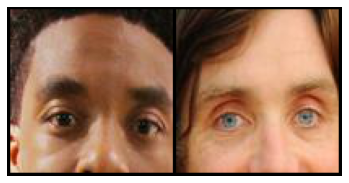

Dissimilar picture : 1.0
cosine dissimilarity for our model 0.015073776245117188
cosine dissimilarity for vgg2 model 5.501508712768555e-05


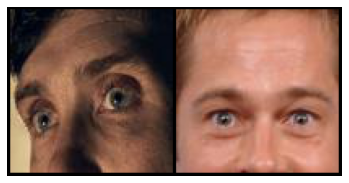

In [ ]:

# tester function to test n image

n = 2

#creating seperate test dataser
folder_dataset_test = dset.ImageFolder(r"./data_crop")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([
                                                                      transforms.ToTensor()
                                                                      ])
                                        ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

for i in range(n):
    bat = next(dataiter)
    concatenated = torch.cat((bat[0],bat[1]),0)

    output1,output2 = net(Variable(bat[0].cuda()),Variable(bat[1]).cuda())
    print("Dissimilar picture : {}".format(bat[2].detach().numpy()[0][0]))
    print("cosine dissimilarity for our model {}".format(cosine(output1.cpu().detach().numpy(),output2.cpu().detach().numpy())))
    # getting image vector from vgg2
    npimg = np.transpose(trans_vgg(bat[0]), (0,2, 3, 1))
    npimg1 = np.transpose(trans_vgg(bat[1]), (0,2, 3, 1))
    samples = preprocess_input(npimg, version=2);samples1 = preprocess_input(npimg1, version=2)
    yhat = model.predict(samples); yhat1 = model.predict(samples1)
    print("cosine dissimilarity for vgg2 model {}".format(  cosine(yhat,yhat1)))
    #euclidean_distance = cosine(output1.cpu().detach().numpy(), output2.cpu().detach().numpy())
    imshow(torchvision.utils.make_grid(concatenated))

In [ ]:
# tester function to test mass image

total_checks= 128

test_dataloader1 = DataLoader(siamese_dataset,num_workers=0,batch_size=total_checks,shuffle=True)
dataiter1 = iter(test_dataloader1)

model_diss,vgg_diss,model_sim,vgg_sim = 0,0,0,0

for i, data in enumerate(test_dataloader1,0):
     img0, img1 , label = data
     output1,output2 = net(Variable(img0.cuda()),Variable(img1.cuda()))
     npimg = np.transpose(trans_vgg(img0), (0,2, 3, 1))
     npimg1 = np.transpose(trans_vgg(img1), (0,2, 3, 1))
     samples = preprocess_input(npimg, version=2);samples1 = preprocess_input(npimg1, version=2)
     yhat = model.predict(samples); yhat1 = model.predict(samples1)
     print(label.shape[0])
     for i in range(label.shape[0]):
       if(label[i]==1):
         if(cosine(yhat[i],yhat1[i]) < cosine(output1[i].cpu().detach().numpy(),output2[i].cpu().detach().numpy())):
           model_diss+=1
         else:
           vgg_diss+=1
       if(label[i]==0):
         if(cosine(yhat[i],yhat1[i]) > cosine(output1[i].cpu().detach().numpy(),output2[i].cpu().detach().numpy())):
           model_sim+=1
         else:
           vgg_sim+=1
     print("model better than vgg for dissimilar images {}".format(model_diss))
     print("model worse than vgg for dissimilar images {}".format(vgg_diss))
     print("model better than vgg for similar images {}".format(model_sim))
     print("model worse than vgg for similar images {}".format(vgg_sim))
     break


128
model better than vgg for dissimilar images 58
model worse than vgg for dissimilar images 1
model better than vgg for similar images 37
model worse than vgg for similar images 32
